<a href="https://colab.research.google.com/github/Zak-Rey/CNN/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-08-30 18:41:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  25.1MB/s    in 4.2s    

2023-08-30 18:41:45 (19.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [7]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-08-30 18:42:31--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.128, 173.194.174.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.2MB/s    in 3.2s    

2023-08-30 18:42:34 (20.2 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale =1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 50,
    verbose = 2
)

Epoch 1/20
100/100 - 181s - loss: 0.3304 - accuracy: 0.8650 - val_loss: 0.1363 - val_accuracy: 0.9500 - 181s/epoch - 2s/step
Epoch 2/20
100/100 - 175s - loss: 0.2082 - accuracy: 0.9160 - val_loss: 0.1033 - val_accuracy: 0.9610 - 175s/epoch - 2s/step
Epoch 3/20
100/100 - 174s - loss: 0.1538 - accuracy: 0.9390 - val_loss: 0.0944 - val_accuracy: 0.9720 - 174s/epoch - 2s/step
Epoch 4/20
100/100 - 183s - loss: 0.1825 - accuracy: 0.9365 - val_loss: 0.0905 - val_accuracy: 0.9660 - 183s/epoch - 2s/step
Epoch 5/20
100/100 - 178s - loss: 0.1756 - accuracy: 0.9330 - val_loss: 0.0855 - val_accuracy: 0.9710 - 178s/epoch - 2s/step
Epoch 6/20
100/100 - 177s - loss: 0.1533 - accuracy: 0.9380 - val_loss: 0.1203 - val_accuracy: 0.9620 - 177s/epoch - 2s/step
Epoch 7/20
100/100 - 180s - loss: 0.1494 - accuracy: 0.9445 - val_loss: 0.0956 - val_accuracy: 0.9660 - 180s/epoch - 2s/step
Epoch 8/20
100/100 - 172s - loss: 0.1565 - accuracy: 0.9405 - val_loss: 0.0692 - val_accuracy: 0.9750 - 172s/epoch - 2s/step


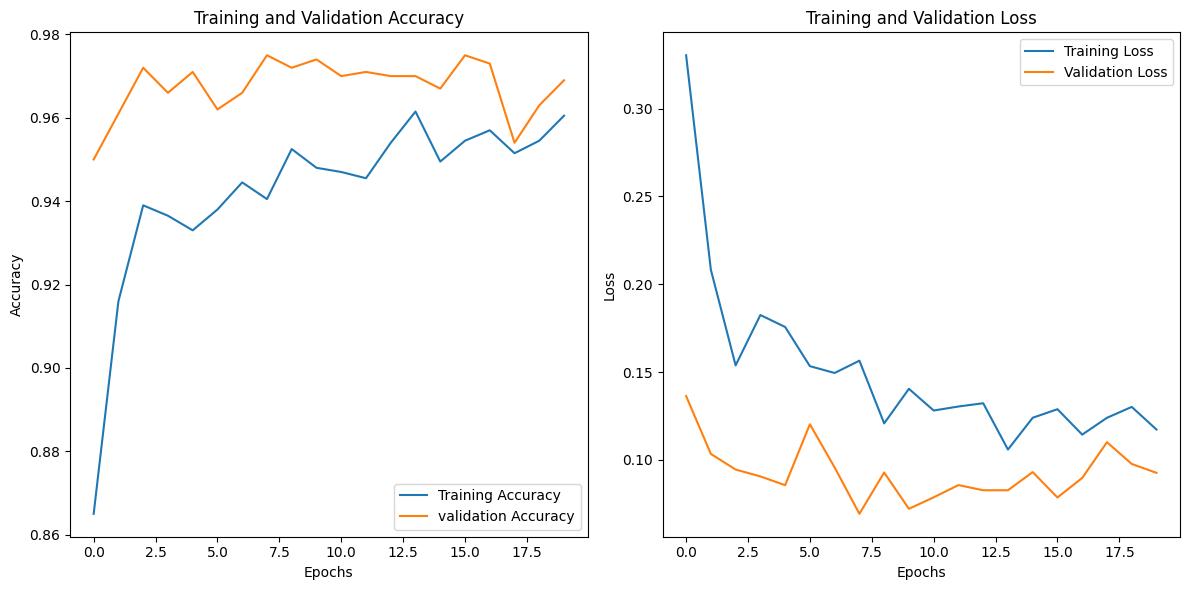

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label= 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()